In [629]:
from astropy.table import Table
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import random
import math
import statistics
from scipy import special, optimize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [630]:
t= Table.read('solar_twins_data.fits') #fits file as table 

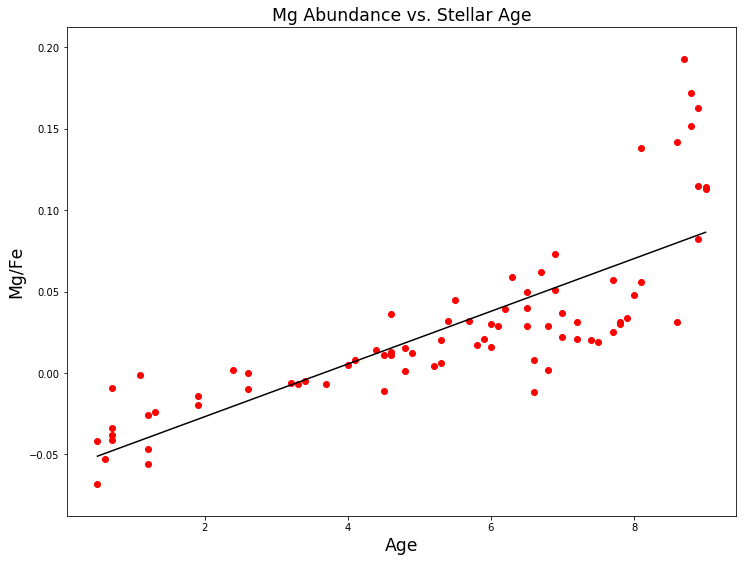

In [631]:
#plot of star age vs Mg abundance from above table
plt.scatter(t['age'], t['Mg'], c='r') 
plt.xlabel('Age',fontsize='xx-large')
plt.ylabel('Mg/Fe', fontsize='xx-large')
plt.title('Mg Abundance vs. Stellar Age', fontsize='xx-large')
plt.plot(np.unique(t['age']), np.poly1d(np.polyfit(t['age'], t['Mg'], 1))(np.unique(t['age'])), color='black')

In [632]:
#importing all data from condensation_temperature
from condensation_temperature import * 

In [633]:
#function that returns temp when given an element
get_tc('O');

In [634]:
#tc_map is a dictionary of elements : condensation temp
#accessing temp from element with tc_map
tc_map['O'];

In [635]:
#creating a table of only one selected star
HIP10175_tbl = t[0] 
HIP10175_tbl;

In [636]:
#accessing only the element columns in the selected star's table and adding them to a list
elements =[]
tablenames = HIP10175_tbl.columns[3:64]
for n in tablenames:
    if len(n) < 3 :
        elements.append(n)
    elements

In [637]:
#list of abundances, in the same order as the elements list
abundance = []
for n in elements:
    abundance.append(HIP10175_tbl[n])
abundance;

In [638]:
#list of condensation temps, in the same order as the elements list
temp = []
for n in elements:
    temp.append(tc_map[n])
temp;

In [639]:
#list of element_err
error_elements = []
for r in tablenames:
    if len(r) > 3 :
        error_elements.append(r)

In [640]:
#list of error values for elements
error = []
for k in error_elements:
    error.append(HIP10175_tbl[k])
error;

In [641]:
#table of element, abundance and temperature
from astropy.table import Table
HIP10175_table = Table([elements, abundance, error, temp], names=('Element', 'Abundance',
        'Abundance Error','Condensation Temp'))

In [642]:
#function for returning the best slope and intercept using linear algebra
#[m b] = [A^T C^-1 A]^-1 [A^T C^-1 Y]
def find_m_b(x,y,err):
    errorsq = np.square(err)
    C = np.diag(errorsq)
    xb = ([1] * len(x))
    mata = []
        
    for z, txt in enumerate(x):
        mata.append(x[z])
        mata.append(xb[z])
            
    A= np.matrix(mata).reshape((len(x), 2))
    At = np.transpose(A)
    invC = np.linalg.inv(C)
    pt1 = np.dot(At, np.dot(invC,A))
    invpt1= np.linalg.inv(pt1)
    pt2 = np.dot(At, np.dot(invC, y)).T
    cov = np.dot(invpt1, pt2)
        
    m_= float(cov[0])
    b_= float(cov[1])
    return m_,b_ 

In [643]:
m_b = find_m_b(temp,abundance,error)
print(m_b)

(9.441261972252866e-05, -0.12154306680819207)


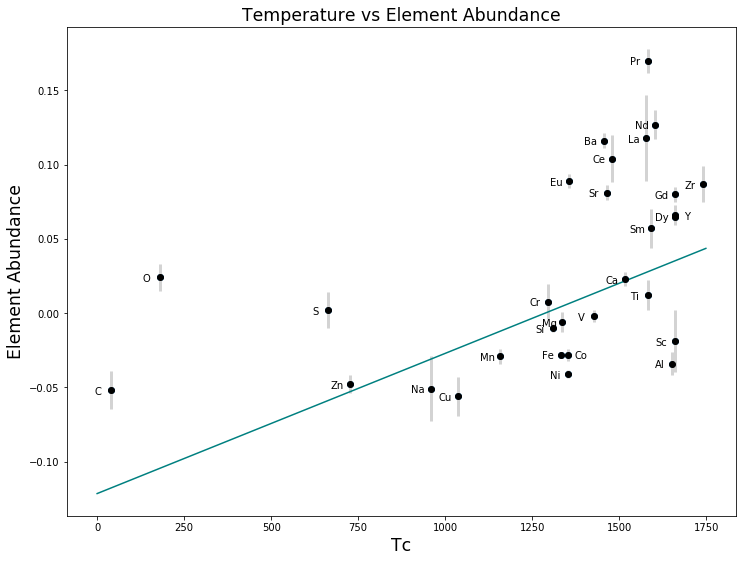

In [644]:
#plotting values for star temp and abundance
plt.scatter(temp, abundance)
plt.xlabel('Tc',fontsize='xx-large', family='sans-serif')
plt.ylabel('Element Abundance', fontsize='xx-large', family='sans-serif')
plt.title('Temperature vs Element Abundance', fontsize= 'xx-large', family='sans-serif')
    
#point labels
for i, txt in enumerate(elements):
    if txt == 'Y' :
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(13,-6), 
           textcoords='offset points', ha='center', va='bottom')
    elif txt == 'Co' :
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(13,-6), 
            textcoords='offset points', ha='center', va='bottom') 
    else : 
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(-13,-6), 
            textcoords='offset points', ha='center', va='bottom')

#error bars
plt.errorbar(temp, abundance, yerr= error, fmt='o', color='black',
                 ecolor='lightgray', elinewidth=3,capsize=0)
m= m_b[0]
b= m_b[1]

temparray=np.array(temp)
plot_xs = np.arange(1750)
plt.plot(plot_xs, m * plot_xs + b, color='teal')

In [645]:
print(m)
print(b)

9.441261972252866e-05
-0.12154306680819207


In [646]:
#function that returns an table with an inputted star's elements, abundance, error and temp
def find_stellar_abundances(star):
    for i, txt in enumerate(t['star_name']):
        if txt == star:
            tbl = t[i] #inputted star's row
            tbl

    star_elements =[]
    elnames = tbl.columns[3:64]
    for n in elnames:
        if len(n) < 3 :
            star_elements.append(n)
            star_elements #list of elements in that star
    
    star_abundance = []
    for n in star_elements:
        star_abundance.append(tbl[n])
        star_abundance #list of element abundances
        
    star_con_temp = []
    for n in star_elements:
        star_con_temp.append(tc_map[n])
        star_con_temp #condensation temperatures for stellar elements
    
    star_error_elements = []
    for r in elnames:
        if len(r) > 3 :
            star_error_elements.append(r)

    el_error = []
    for k in star_error_elements:
        el_error.append(tbl[k])
        el_error #list of error values for elements
    
    star_table = Table([star_elements, star_abundance, el_error, star_con_temp], names=('Element', 'Abundance',
        'Abundance Error','Condensation Temp'))
    return star_table

In [647]:
#function that returns a plot of an inputted star's temperature vs element abundance
def stellar_abundance_plot(star): 
    for i, txt in enumerate(t['star_name']):
        if txt == star:
            tbl = t[i] #inputted star's row
            tbl

    star_elements =[]
    elnames = tbl.columns[3:64]
    for n in elnames:
        if len(n) < 3 :
            star_elements.append(n)
            star_elements #list of elements in that star
    
    star_abundance = []
    for n in star_elements:
        star_abundance.append(tbl[n])
        star_abundance #list of element abundances
        
    star_con_temp = []
    for n in star_elements:
        star_con_temp.append(tc_map[n])
        star_con_temp #condensation temperatures for stellar elements
    new=np.array(star_con_temp)
    
    star_error_elements = []
    for r in elnames:
        if len(r) > 3 :
            star_error_elements.append(r)

    el_error = []
    for k in star_error_elements:
        el_error.append(tbl[k])
        el_error #list of error values for elements
    
    star_table = Table([star_elements, star_abundance, el_error, star_con_temp], names=('Element', 'Abundance',
        'Abundance Error','Condensation Temp'))

    plt.scatter(star_con_temp, star_abundance)
    plt.xlabel('Tc',fontsize='xx-large', family='sans-serif')
    plt.ylabel('Element Abundance', fontsize='xx-large', family='sans-serif')
    plt.title('Temperature vs Element Abundance', fontsize= 'xx-large', family='sans-serif')

    #point labels
    for i, txt in enumerate(elements):
            plt.annotate(txt, xy=(star_con_temp[i], star_abundance[i]), xytext=(-13,-6), 
                textcoords='offset points', ha='center', va='bottom')

    #error bars
    plt.errorbar(star_con_temp, star_abundance, yerr= el_error, fmt='o', color='black',
                 ecolor='lightgray', elinewidth=3,capsize=0)
    
    #line of best fit m,b values
    mb = find_m_b(star_con_temp, star_abundance, el_error)    
    plot_xs = np.arange(1750)
    plt.plot(plot_xs, (mb[0]) * plot_xs + (mb[1]), color='teal')
    return plt

In [648]:
#jackknife method for determining other possible values of m and b 
def jackknifemb(_tp,_ab,_er):
    N=1000
    l=list(np.copy(_tp))
    k=list(np.copy(_ab))
    s=list(np.copy(_er))
    jackm= []
    jackb= [] 
    h=0
    
    #leaving out one point from data set and calculating m, b for each instance
    while h<N:
        w = random.randint(0, 29)
        del l[w]
        del k[w]
        del s[w] #removing one data set from lists 
    
        jk_mb = find_m_b(l,k,s)
        jk_m = jk_mb[0]
        jk_b = jk_mb[1]

        jackm.append(jk_m)
        jackb.append(jk_b)
            
        l=list(np.copy(_tp))
        k=list(np.copy(_ab))
        s=list(np.copy(_er))
        h=h+1 
        
    return jackm, jackb

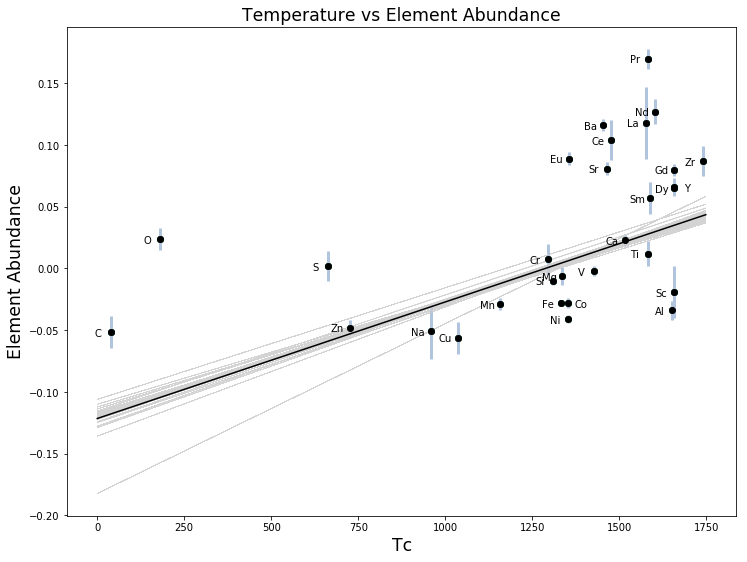

In [649]:
jk= jackknifemb(temp, abundance, error)
for i, txt in enumerate (jk[0]):
    plt.scatter(temp, abundance)
    plt.xlabel('Tc',fontsize='xx-large', family='sans-serif')
    plt.ylabel('Element Abundance', fontsize='xx-large', family='sans-serif')
    plt.title('Temperature vs Element Abundance', fontsize= 'xx-large', family='sans-serif')

    temparray=np.array(temp)
    plot_xs = np.arange(1750)
    plt.plot(plot_xs, jk[0][i] * plot_xs + (jk[1][i]), color = 'lightgray', linewidth=0.1)

for i, txt in enumerate(elements):
    if txt == 'Y' :
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(13,-6), 
            textcoords='offset points', ha='center', va='bottom')
    elif txt == 'Co' :
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(13,-6), 
            textcoords='offset points', ha='center', va='bottom') 
    else : 
        plt.annotate(txt, xy=(temp[i], abundance[i]), xytext=(-13,-6), 
            textcoords='offset points', ha='center', va='bottom')

#error bars
plt.errorbar(temp, abundance, yerr= error, fmt='o', color='black',
                    ecolor='lightsteelblue', elinewidth=3,capsize=0)
plt.plot(plot_xs, m * plot_xs + b, color='black')

original value = -0.12154306680819207


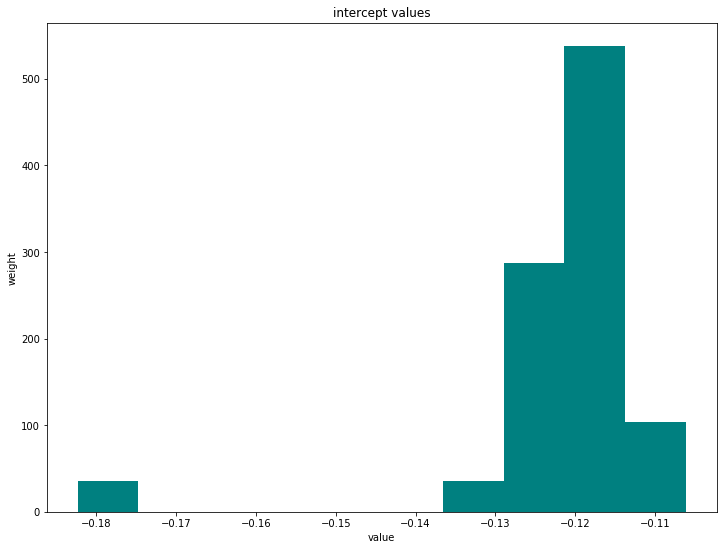

In [650]:
x = jk[1]
plt.hist(x, color = 'teal')
plt.ylabel('weight')
plt.xlabel('value')
plt.title('intercept values')
print('original value =', b)

original value =  9.441261972252866e-05


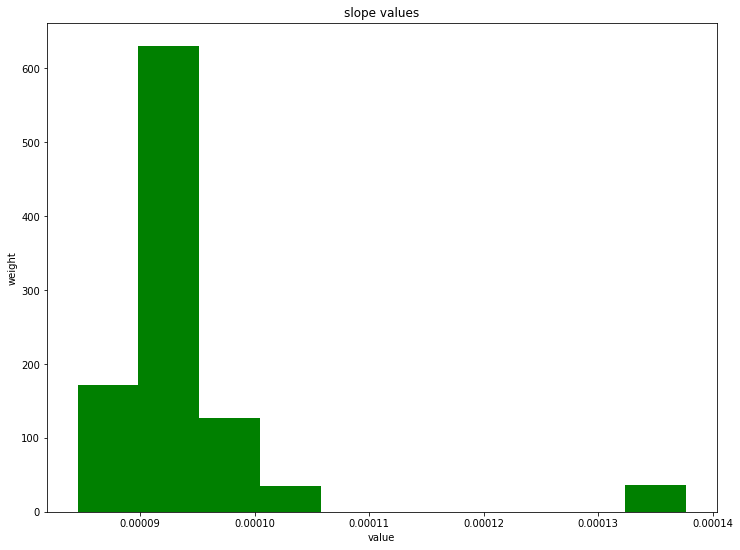

In [651]:
x = jk[0]
plt.hist(x, color = 'green')
plt.ylabel('weight')
plt.xlabel('value')
plt.title('slope values')
print('original value = ', m)

In [652]:
#standard slope error : [A^T C^-1 A]^-1
errorsq = np.square(error)
errorC = np.diag(errorsq)
abu = ([1] * len(temp))
atemper = np.copy(temp)
matri = []
        
for z, txt in enumerate(atemper):
    matri.append(atemper[z])
    matri.append(abu[z])
            
aa= np.matrix(matri).reshape((len(temp), 2))
Att = np.transpose(aa)
inverrorC = np.linalg.inv(errorC)
prt1 = np.dot(Att, np.dot(inverrorC,aa))
invt1= np.linalg.inv(prt1)
prt2 = np.dot(Att, np.dot(inverrorC, abundance)).T
covar = np.dot(invt1, prt2)
        
_m_= float(covar[0])
_b_= float(covar[1])
print('the standard slope value is', _m_)
print('the standard intercept value is',_b_)
    
inbrackets = np.dot(Att, np.dot(inverrorC, aa))
sserror = np.linalg.inv(inbrackets)
#sserror = [σ^2m, σmb, σmb, σ^2b]
print('the standard slope error is',np.sqrt(sserror[0,0]))
print('the standard intercept error is',np.sqrt(sserror[1,1]))

the standard slope value is 9.441261972252866e-05
the standard intercept value is -0.12154306680819207
the standard slope error is 4.049628887302976e-06
the standard intercept error is 0.005579846451640529


In [653]:
#overall standard deviation
stdev_m = statistics.stdev(jk[0])
stdev_b = statistics.stdev(jk[1])

print(stdev_m)
print(stdev_b)

9.200078924224158e-06
0.012938523518102055


In [654]:
#standard deviation without outliers
m_nooutliers = []
for t in jk[0]:
    if t < 0.00013:
        m_nooutliers.append(t)
print(statistics.stdev(m_nooutliers))

b_nooutliers = []
for p in jk[1]:
    if p > -0.17:
        b_nooutliers.append(p)
print(statistics.stdev(b_nooutliers))

4.066649335957043e-06
0.005688734456174182


In [655]:
error_type = ['slope', 'intercept']
a = [9.44e-5, -.121]
b = [3.9e-6,.0055]
c = [8.05e-6,.0114]
d = [4.0496e-06,0.0056]
z = Table([error_type,a, c, b, d], names=('error type', 'value','standard dev with outliers', 
                                          'standard dev without outliers',  'linear algebra uncertainty'))
z 

error type,value,standard dev with outliers,standard dev without outliers,linear algebra uncertainty
str9,float64,float64,float64,float64
slope,9.44e-05,8.05e-06,3.9e-06,4.0496e-06
intercept,-0.121,0.0114,0.0055,0.0056


In [668]:
#chi squared :  [Y - AX]^T C^-1 [Y - AX]
def chisquared(x,y,erro): 
    ab = ([1] * len(x))
    Amat = []
    for z, txt in enumerate(x):
        Amat.append(x[z])
        Amat.append(ab[z])  
    A= np.matrix(Amat).reshape((len(x), 2))

    errorsq = np.square(erro)
    C = np.diag(errorsq)
    invsC = np.linalg.inv(C)

    AT= np.transpose(A)
    part1 = np.dot(AT, np.dot(invsC, A))
    invprt1= np.linalg.inv(part1)
    part2 = np.dot(AT, np.dot(invsC, y)).T
    X = np.dot(invprt1, part2)

    yax = (Y - (np.dot(A,X)))
    yaxT = np.transpose(yax)
    yaxTinvsC = np.dot(yaxT, invsC)

    chisq = (np.dot(yaxTinvsC, yax))
    return (np.array(chisq))